In [1]:
import logging

import numpy as np
import torch
import tqdm
from torch import nn
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import pickle

In [215]:
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
from obp.dataset import SyntheticBanditDataset
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPW,
    DirectMethod as DM,
    DoublyRobust as DR,
)
from obp.policy import IPWLearner, NNPolicyLearner

In [3]:
from obp.dataset import MultiClassToBanditReduction
from sklearn.model_selection import train_test_split


In [4]:
class Net(nn.Module):
    def __init__(self, num_questions, hidden_size, num_layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_size
        self.layer_dim = num_layers
        self.rnn = nn.RNN(num_questions * 2, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_dim, num_questions)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.layer_dim,  self.hidden_dim))
        out, _ = self.rnn(x, h0)
        res = torch.sigmoid(self.fc(out))
        return res,out


In [5]:
df=pd.read_csv('attempts.csv')

In [6]:
df.problem=df.problem.replace(86,25)

In [15]:
student_l={}
for j in df.student.unique():
    student_l[j]=df[df.student==j][['problem','solved']]

In [7]:
with open('good_list.pkl', 'rb') as f:
    good_list= pickle.load(f)
    

In [8]:
dkt=Net(num_questions=85,hidden_size=5,num_layers=3)

In [9]:
dkt.load_state_dict(torch.load('weights.pth'))

<All keys matched successfully>

In [10]:
context_l={}
for j in df.student.unique():
    
    _,context_l[j]=dkt(good_list[j])

In [59]:
kmeans = KMeans(n_clusters=50, random_state=130, n_init="auto").fit(dbf.values[:,:-2])

In [61]:
new_context=kmeans.labels_

In [77]:
np.c_[new_context[m.index],m.values]

array([[1, 2, True],
       [21, 12, True],
       [27, 10, True],
       [20, 14, True],
       [42, 11, True],
       [29, 1, True],
       [27, 3, True],
       [39, 49, True],
       [13, 17, True],
       [18, 8, True]], dtype=object)

In [72]:
student_l

{29:    problem  solved
 0        2    True
 1       12    True
 2       10    True
 3       14    True
 4       11    True
 5        1    True
 6        3    True
 7       49    True
 8       17    True
 9        8    True,
 584:     problem  solved
 10        2    True
 11       31    True
 12       12    True
 13        8    True
 14        6    True
 15       13    True
 16       23    True
 17       21    True
 18        3    True
 19       53    True
 20       17    True
 21       50    True
 22       41    True
 23       37    True
 24       60    True
 25       55    True,
 769:     problem  solved
 26       31    True
 27       49    True,
 909:     problem  solved
 28       26   False,
 917:     problem  solved
 29       26   False,
 971:     problem  solved
 30       31    True,
 1027:     problem  solved
 31        2   False,
 1181:     problem  solved
 32       17   False,
 1218:     problem  solved
 33       31   False,
 1219:     problem  solved
 34       44    True
 35 

In [13]:
colums=np.r_[np.array(['feature'+str(j) for j in range(1,6)]),['action','reward']]

In [78]:
dicpanda={}
for j in df.student.unique():
    m=student_l[j]
    dicpanda[j]=pd.DataFrame(data=np.c_[new_context[m.index],m.values],columns=['context','action','reward'])

In [80]:
dbf=np.concatenate([dicpanda[j] for j in df.student.unique()],axis=0)
dbf=pd.DataFrame(data=dbf,columns=['context','action','reward'])

In [86]:
contextgroup=dbf.groupby(['context','action']).describe()

In [212]:
dex=pd.DataFrame(index=np.arange(0,50),columns=np.arange(1,86))
for a,b in contextgroup['reward'].index:
    
    m=contextgroup['reward'].loc[(a,b)]
    
    dex[b][a]=(m.loc['freq']/m.loc['count']) if m.top else ((m.loc['count']-m.loc['freq'])/m.loc['count'])


<Axes: >

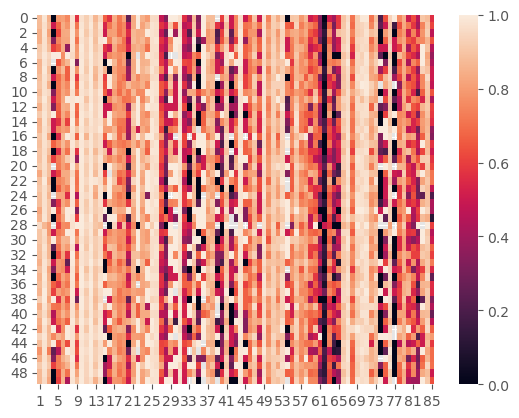

In [217]:
sns.heatmap(dex.astype(float))

In [203]:
dbf[dbf.action==1]

,context,action,reward
5,29,1,True
70,40,1,True
143,49,1,True
166,43,1,True
272,14,1,True
...,...,...,...
285443,45,1,True
285656,15,1,True
285694,22,1,True
285708,29,1,True


In [21]:
y=dbf['action'].astype(int)-1

In [22]:
dataset = MultiClassToBanditReduction(
    X=dbf[[ 'feature1', 'feature2', 'feature3','feature4','feature5']],
    y=y,
    base_classifier_b=LogisticRegression(random_state=12345),
    alpha_b=0.8,
    n_deficient_actions=0
 
)

In [23]:
dataset.split_train_eval(eval_size=0.7, random_state=12345)

In [30]:
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(random_state=1234)
bandit_feedback_test =dataset.obtain_batch_bandit_feedback(random_state=1234)

/opt/homebrew/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

In [38]:
action_dist=dataset.obtain_action_dist_by_eval_policy()

/opt/homebrew/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
behavior_policy=

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

In [118]:
train_test_split([3,2,4,2])

[[2, 3, 2], [4]]

In [122]:
bandit_feedback_train.pop('n_actions')
bandit_feedback_train.pop('n_rounds')


200068

In [128]:
bdf_train={}
bdf_test={}
for a,b in bandit_feedback_train.items():
    bdf_train[a],bdf_test[a]=train_test_split(b,random_state=0,test_size=0.5)

In [130]:
bdf_train['n_rounds']=bdf_train['context'].shape[0]
bdf_train['n_actions']=85
bdf_test['n_actions']=85
bdf_test['n_rounds']=bdf_test['context'].shape[0]
bdf_train['position']=None
bdf_test['position']=None


In [131]:
eval_policy = IPWLearner(n_actions=85, base_classifier=LogisticRegression())

In [116]:
for j in bandit_feedback_train.keys():
    print(j)

n_actions
n_rounds
context
action
reward
position
pi_b
pscore


In [132]:
bdf_feedback_train=bdf_train
bdf_feedback_test=bdf_test

In [138]:
from obp.policy import QLearner
from obp.ope import SelfNormalizedInverseProbabilityWeighting
from sklearn.ensemble import RandomForestClassifier

In [139]:
qlearner=QLearner(n_actions=85,base_model=LogisticRegression())
eval_policy = IPWLearner(n_actions=85, base_classifier=LogisticRegression())
eval_policy_rf = IPWLearner(
    n_actions=85,
    base_classifier=RandomForestClassifier(
        n_estimators=100, max_depth=5, min_samples_leaf=10, random_state=12345
    ),
)
qlearner.fit(
    context=bdf_feedback_train["context"],
    action=bdf_feedback_train["action"],
    reward=bdf_feedback_train["reward"],
    pscore=bdf_feedback_train["pscore"]
)
eval_policy.fit(
    context=bdf_feedback_train["context"],
    action=bdf_feedback_train["action"],
    reward=bdf_feedback_train["reward"],
    pscore=bdf_feedback_train["pscore"]
)
eval_policy_rf.fit(
    context=bdf_feedback_train["context"],
    action=bdf_feedback_train["action"],
    reward=bdf_feedback_train["reward"],
    pscore=bdf_feedback_train["pscore"]
)

#obtaining the new policy
qlearner_dist=qlearner.predict(bdf_feedback_test["context"])
eval_policy_dist=eval_policy.predict(bdf_feedback_test["context"])
eval_policy_rf_dist=eval_policy_rf.predict(bdf_feedback_test["context"])
optimal_dist=ac_opt


/opt/homebrew/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

NameError: name 'ac_opt' is not defined

In [140]:
ipw=IPW()
dm=DM()
dr=DR()

In [141]:
regression_model = RegressionModel(
    n_actions=85,
    base_model=LogisticRegression(),
)
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bdf_feedback_test["context"],
    action=bdf_feedback_test["action"],
    reward=bdf_feedback_test["reward"],
)

/opt/homebrew/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [144]:
v_df=pd.DataFrame(index=['policy_of_IPW_random_forest','policy_of_IPW_logistic_regression','policy_of_DM',
                               'optimal_policy','behavior_policy'],columns=['IPW_estimator','DM_estimator','DR_estimator','ground_truth'])

v_df.loc['policy_of_IPW_random_forest','IPW_estimator']=ipw.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=eval_policy_rf_dist)

v_df.loc['policy_of_IPW_logistic_regression','IPW_estimator']=ipw.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=eval_policy_dist)

v_df.loc['policy_of_DM','IPW_estimator']=ipw.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=qlearner_dist)

#v_df.loc['optimal_policy','IPW_estimator']=ipw.estimate_policy_value(reward=bdf_feedback_test["reward"],
#                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
#                                  action_dist=optimal_dist)
v_df.loc['behavior_policy','IPW_estimator']=ipw.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=bdf_feedback_test["pi_b"])

v_df.loc['policy_of_IPW_random_forest','DR_estimator']=dr.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=eval_policy_rf_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)

v_df.loc['policy_of_IPW_logistic_regression','DR_estimator']=dr.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=eval_policy_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)

v_df.loc['policy_of_DM','DR_estimator']=dr.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=qlearner_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)

#v_df.loc['optimal_policy','DR_estimator']=dr.estimate_policy_value(reward=bdf_feedback_test["reward"],
#                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
#                                  action_dist=optimal_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)
v_df.loc['behavior_policy','DR_estimator']=dr.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=bdf_feedback_test["pi_b"],estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)

v_df.loc['policy_of_IPW_random_forest','DM_estimator']=dm.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=eval_policy_rf_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)

v_df.loc['policy_of_IPW_logistic_regression','DM_estimator']=dm.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=eval_policy_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)

v_df.loc['policy_of_DM','DM_estimator']=dm.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=qlearner_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)

#v_df.loc['optimal_policy','DM_estimator']=dm.estimate_policy_value(reward=bdf_feedback_test["reward"],
#                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
#                                  action_dist=optimal_dist,estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)
v_df.loc['behavior_policy','DM_estimator']=dm.estimate_policy_value(reward=bdf_feedback_test["reward"],
                                  action=bdf_feedback_test["action"],pscore=bdf_feedback_test["pscore"],
                                  action_dist=bdf_feedback_test["pi_b"],estimated_rewards_by_reg_model=estimated_rewards_by_reg_model)



In [145]:
v_df

,IPW_estimator,DM_estimator,DR_estimator,ground_truth
policy_of_IPW_random_forest,0.336321,0.323458,0.330557,NaN
policy_of_IPW_logistic_regression,0.33581,0.300608,0.330297,NaN
policy_of_DM,0.044566,0.639419,0.064806,NaN
optimal_policy,NaN,NaN,NaN,NaN
behavior_policy,0.268269,0.267717,0.267753,NaN


In [32]:
eval_policy.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)
action_dist = eval_policy.predict(context=bandit_feedback_test["context"])


ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_test,
    ope_estimators=[IPW(), DM(), DR()]
)

/opt/homebrew/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
regression_model = RegressionModel(
    n_actions=85,
    base_model=LogisticRegression(),
)
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback_test["context"],
    action=bandit_feedback_test["action"],
    reward=bandit_feedback_test["reward"],
)

/opt/homebrew/anaconda3/envs/newenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/Users/samuelgirard/zr-obp/obp/ope/meta.py:640: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95.0)` for the same effect.

  sns.barplot(


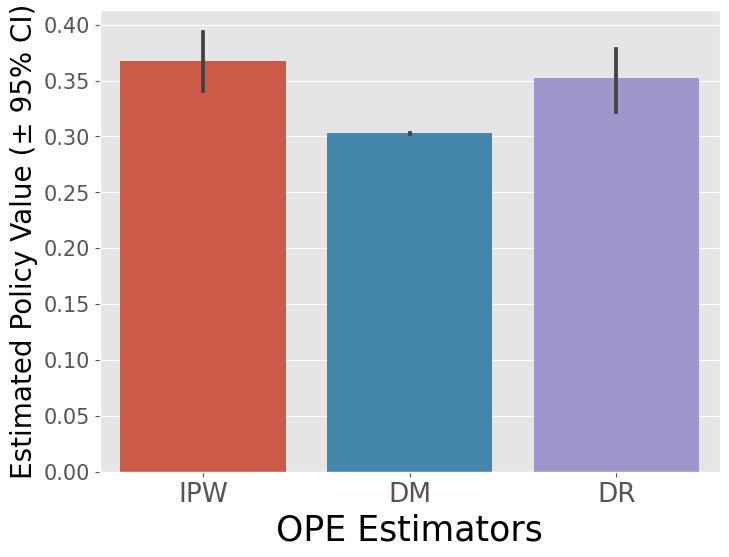

In [36]:
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
)



In [110]:
X=dbf[[ 'feature1', 'feature2', 'feature3','feature4','feature5']]
y=dbf['action']
n_rounds=X.shape[0]
n_actions=85
y = (y - 1).astype(int)
y_full = np.zeros((n_rounds, n_actions))
y_full[np.arange(n_rounds), y] = 1


In [113]:
y_full.shape

(285811, 85)

In [118]:
X_tr,X_ev,y_tr,y_ev, _,y_full_ev=train_test_split(
            X, y, y_full, test_size=0.7, random_state=0)

In [ ]:
# construct a behavior policy
pi_b = np.zeros((n_rounds_ev, self.n_actions))
pi_b[:, :] = (1.0 - self.alpha_b) / self.n_actions
pi_b[np.arange(self.n_rounds_ev), preds] = (
    self.alpha_b + (1.0 - self.alpha_b) / self.n_actions
)

In [120]:
n_rounds_ev=y_full_ev.shape[0]

base_clf_b=LogisticRegression()
base_clf_b.fit(X=X_tr, y=y_tr)
preds = base_clf_b.predict(X_ev).astype(int)




/home/samuelgirard/anaconda3/envs/Soda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [127]:
dbf.iloc[X_ev.index].action.values

array([25, 10, 31, ..., 26, 13,  6])

In [121]:
preds,X_ev

(array([ 7,  9, 43, ..., 25,  9,  5]),
         feature1  feature2  feature3  feature4  feature5
 29067   0.036724 -0.267159 -0.199404 -0.726626  0.721652
 28271   0.317186 -0.230486 -0.154534 -0.820948  0.813592
 127451  0.221818 -0.233303 -0.045783 -0.800312  0.819073
 215246  0.221738 -0.198332  -0.30802 -0.753219   0.79213
 256285  0.185732 -0.270909 -0.149734  -0.73104  0.741352
 ...          ...       ...       ...       ...       ...
 192121  0.206068 -0.264001 -0.104711 -0.777079  0.752516
 111134  0.210642 -0.204296 -0.073758  -0.81618   0.81144
 115676  0.340878 -0.208251 -0.453772 -0.767611  0.819795
 246991  0.281946 -0.258849 -0.281579 -0.768967  0.814557
 67667   0.204897  -0.17161 -0.220225 -0.773431  0.785978
 
 [200068 rows x 5 columns])

In [ ]:
pi_b = np.zeros((self.n_rounds_ev, self.n_actions))
pi_b[:, :] = (1.0 - self.alpha_b) / self.n_actions
pi_b[np.arange(self.n_rounds_ev), preds] = (
    self.alpha_b + (1.0 - self.alpha_b) / self.n_actions
)
if self.n_deficient_actions > 0:
    deficient_actions = np.argsort(
        random_.gumbel(size=(self.n_rounds_ev, self.n_actions)), axis=1
    )[:, ::-1][:, : self.n_deficient_actions]
    deficient_actions_idx = (
        np.tile(np.arange(self.n_rounds_ev), (self.n_deficient_actions, 1)).T,
        deficient_actions,
    )
    pi_b[deficient_actions_idx] = 0.0  # create some deficient actions
    pi_b /= pi_b.sum(1)[
        :, np.newaxis
    ]  # re-normalize the probability distribution
# sample actions and factual rewards
actions = sample_action_fast(pi_b, random_state=random_state)
rewards = self.y_full_ev[np.arange(self.n_rounds_ev), actions]
